# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import seaborn as sns
from sklearn.metrics.pairwise import linear_kernel,cosine_similarity
from sklearn.metrics import accuracy_score, f1_score, classification_report, recall_score, precision_score

%matplotlib inline

In [2]:
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [3]:
# show a sample title in df
df[df.article_id==2].title.unique()

array(['this week in data science (april 18, 2017)'], dtype=object)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null float64
title         45993 non-null object
email         45976 non-null object
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [5]:
df.drop_duplicates().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33682 entries, 0 to 45992
Data columns (total 3 columns):
article_id    33682 non-null float64
title         33682 non-null object
email         33669 non-null object
dtypes: float64(1), object(2)
memory usage: 1.0+ MB


In [6]:
df.email.describe()

count                                        45976
unique                                        5148
top       2b6c0f514c2f2b04ad3c4583407dccd0810469ee
freq                                           364
Name: email, dtype: object

In [7]:
df.article_id.describe()

count    45993.000000
mean       908.846477
std        486.647866
min          0.000000
25%        460.000000
50%       1151.000000
75%       1336.000000
max       1444.000000
Name: article_id, dtype: float64

In [8]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [9]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
doc_body           1042 non-null object
doc_description    1053 non-null object
doc_full_name      1056 non-null object
doc_status         1056 non-null object
article_id         1056 non-null int64
dtypes: int64(1), object(4)
memory usage: 41.3+ KB


In [10]:
df_content.doc_status.describe()

count     1056
unique       1
top       Live
freq      1056
Name: doc_status, dtype: object

In [11]:
df_content.doc_body.describe()

count                                                  1042
unique                                                 1036
top       Working Vis * \r\n * \r\n\r\n * Home\r\n * Abo...
freq                                                      4
Name: doc_body, dtype: object

In [12]:
# show a sample of doc_body from df_content
df_content.doc_body[0]

"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VIDEO IS UNAVAILABLE.\r\nWATCH QUEUE\r\nQUEUE\r\nWatch Queue Queue * Remove all\r\n * Disconnect\r\n\r\nThe next video is starting stop 1. Loading...\r\n\r\nWatch Queue Queue __count__/__total__ Find out why CloseDEMO: DETECT MALFUNCTIONING IOT SENSORS WITH STREAMING ANALYTICS\r\nIBM AnalyticsLoading...\r\n\r\nUnsubscribe from IBM Analytics? Cancel UnsubscribeWorking...\r\n\r\nSubscribe Subscribed Unsubscribe 26KLoading...\r\n\r\nLoading...\r\n\r\nWorking...\r\n\r\nAdd toWANT TO WATCH THIS AGAIN LATER?\r\nSign in to add this video to a playlist. Sign in Share More * ReportNEED TO REPORT THE VIDEO?\r\n   Sign in to report inappropriate content. Sign in\r\n * Transcript\r\n * Statistics\r\n * Add translations\r\n\r\n175 views 6LIKE THIS VIDEO?\r\nSign in to make your opinion count. Sign in 7 0DON'T LIKE THIS VIDEO?\r\nSign in to make your opinion count. Sign in 1Loading...\r\n\r\nLoading...\r\n\r\nTRANSCR

In [13]:
df_content.doc_description.describe()

count                                                  1053
unique                                                 1022
top       Here’s this week’s news in Data Science and Bi...
freq                                                     16
Name: doc_description, dtype: object

In [14]:
df_content.doc_description[0]

'Detect bad readings in real time using Python and Streaming Analytics.'

In [15]:
df_content.doc_full_name.describe()

count                      1056
unique                     1051
top       Use the Primary Index
freq                          2
Name: doc_full_name, dtype: object

In [16]:
df_content.article_id.describe()

count    1056.000000
mean      523.913826
std       303.480641
min         0.000000
25%       260.750000
50%       523.500000
75%       786.250000
max      1050.000000
Name: article_id, dtype: float64

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [17]:
# count unique article_id from df.groupby('email')
unique_article_by_email = df.groupby('email').article_id.nunique()
unique_article_by_email.describe()

count    5148.000000
mean        6.540210
std         9.990676
min         1.000000
25%         1.000000
50%         3.000000
75%         7.000000
max       135.000000
Name: article_id, dtype: float64

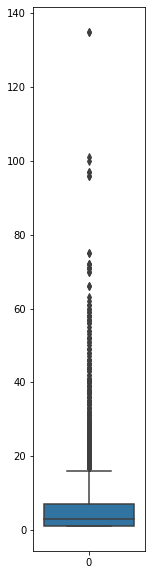

In [18]:
# visual statistic of the distribution of how many articles a user interacts with in the dataset
plt.figure(figsize=(2,10))
sns.boxplot(data=unique_article_by_email);

In [19]:
# Fill in the median and maximum number of user_article interactios below
median_val = unique_article_by_email.median() # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = df.groupby('email').article_id.count().max()# The maximum number of user-article interactions by any 1 user is ______.

In [20]:
max_views_by_user

364

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [21]:
# Find and explore duplicate articles
df_content[df_content.duplicated('article_id',False)].sort_values('article_id')

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


In [22]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates('article_id', keep='first',inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [23]:
# check null value in df
df.isnull().sum()

article_id     0
title          0
email         17
dtype: int64

In [24]:
# df length
df.shape[0]

45993

In [25]:
# when remove null value in email the number of intereactions drops by 17
df.dropna(subset=['article_id','email']).shape[0]

45976

In [26]:
unique_articles = sum(df.groupby('article_id').email.count()>0) # The number of unique articles that have at least one interaction
total_articles = len(df_content.article_id.unique()) # The number of unique articles on the IBM platform
unique_users = df.email.describe()['unique'] # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions???

In [27]:
unique_articles,total_articles

(714, 1051)

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [28]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = str(df.groupby('article_id').email.count().sort_values(ascending=False).index[0])
# The most viewed article in the dataset was viewed how many times?
max_views = df.groupby('article_id').email.count().max()

In [29]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [30]:
# check null value after email mapping
df.isnull().sum()

article_id    0
title         0
user_id       0
dtype: int64

In [31]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [32]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = df.groupby(['article_id','title']).count().sort_values('user_id',ascending=False).head(n).reset_index().title.values
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles_ids - (list) A list of the top 'n' article ids 
    
    '''
    # Your code here
    top_articles_ids = df.groupby(['article_id','title']).count().sort_values('user_id',ascending=False).head(n).reset_index().article_id.values
    top_articles_ids = [str(i) for i in top_articles_ids]
 
    return top_articles_ids # Return the top article ids

In [33]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification'
 'insights from new york car accident reports'
 'visualize car data with brunel'
 'use xgboost, scikit-learn & ibm watson machine learning apis'
 'predicting churn with the spss random tree algorithm'
 'healthcare python streaming application demo'
 'finding optimal locations of new store using decision optimization'
 'apache spark lab, part 1: basic concepts'
 'analyze energy consumption in buildings'
 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [34]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [35]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [36]:
df.article_id.nunique()

714

In [37]:
df_content.article_id.nunique()

1051

In [38]:
df.user_id.nunique()

5149

In [39]:
df_pivot = df.pivot_table(index='user_id', columns='article_id',aggfunc=lambda x: x.nunique(),fill_value=0)
df_pivot.shape

(5149, 714)

In [40]:
df_pivot.head()

title                                                          \
article_id 0.0    2.0    4.0    8.0    9.0    12.0   14.0   15.0   16.0     
user_id                                                                     
1               0      0      0      0      0      0      0      0      0   
2               0      0      0      0      0      0      0      0      0   
3               0      0      0      0      0      1      0      0      0   
4               0      0      0      0      0      0      0      0      0   
5               0      0      0      0      0      0      0      0      0   

                   ...                                                   \
article_id 18.0    ... 1434.0 1435.0 1436.0 1437.0 1439.0 1440.0 1441.0   
user_id            ...                                                    
1               0  ...      0      0      1      0      1      0      0   
2               0  ...      0      0      0      0      0      0      0   
3               0  ...      0      0      1      0      0      0      0   
4               0  ...      0      0      0      0      0      0      0   
5               0  ...      0      0      0      0      0      0      0   

                                 
article_id 1442.0 1443.0 1444.0  
user_id                          
1               0      0      0  
2               0      0      0  
3               0      0      0  
4               0      0      0  
5               0      0      0  

[5 rows x 714 columns]

In [41]:
df_pivot.describe()

title                                                      \
article_id       0.0          2.0          4.0          8.0          9.0      
count       5149.000000  5149.000000  5149.000000  5149.000000  5149.000000   
mean           0.002331     0.008545     0.002525     0.015925     0.001942   
std            0.048224     0.092054     0.050188     0.125199     0.044031   
min            0.000000     0.000000     0.000000     0.000000     0.000000   
25%            0.000000     0.000000     0.000000     0.000000     0.000000   
50%            0.000000     0.000000     0.000000     0.000000     0.000000   
75%            0.000000     0.000000     0.000000     0.000000     0.000000   
max            1.000000     1.000000     1.000000     1.000000     1.000000   

                                                                             \
article_id       12.0         14.0         15.0         16.0         18.0     
count       5149.000000  5149.000000  5149.000000  5149.000000  5149.000000   
mean           0.019227     0.017285     0.005050     0.010876     0.013206   
std            0.137335     0.130344     0.070887     0.103729     0.114169   
min            0.000000     0.000000     0.000000     0.000000     0.000000   
25%            0.000000     0.000000     0.000000     0.000000     0.000000   
50%            0.000000     0.000000     0.000000     0.000000     0.000000   
75%            0.000000     0.000000     0.000000     0.000000     0.000000   
max            1.000000     1.000000     1.000000     1.000000     1.000000   

            ...                                                      \
article_id  ...       1434.0       1435.0       1436.0       1437.0   
count       ...  5149.000000  5149.000000  5149.000000  5149.000000   
mean        ...     0.006992     0.014566     0.054768     0.024665   
std         ...     0.083331     0.119819     0.227549     0.155117   
min         ...     0.000000     0.000000     0.000000     0.000000   
25%         ...     0.000000     0.000000     0.000000     0.000000   
50%         ...     0.000000     0.000000     0.000000     0.000000   
75%         ...     0.000000     0.000000     0.000000     0.000000   
max         ...     1.000000     1.000000     1.000000     1.000000   

                                                                             \
article_id       1439.0       1440.0       1441.0       1442.0       1443.0   
count       5149.000000  5149.000000  5149.000000  5149.000000  5149.000000   
mean           0.008351     0.001554     0.001165     0.000777     0.002331   
std            0.091011     0.039390     0.034120     0.027864     0.048224   
min            0.000000     0.000000     0.000000     0.000000     0.000000   
25%            0.000000     0.000000     0.000000     0.000000     0.000000   
50%            0.000000     0.000000     0.000000     0.000000     0.000000   
75%            0.000000     0.000000     0.000000     0.000000     0.000000   
max            1.000000     1.000000     1.000000     1.000000     1.000000   

                         
article_id       1444.0  
count       5149.000000  
mean           0.000971  
std            0.031150  
min            0.000000  
25%            0.000000  
50%            0.000000  
75%            0.000000  
max            1.000000  

[8 rows x 714 columns]

In [42]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item = df.pivot_table(index='user_id', columns='article_id',aggfunc=lambda x: x.nunique(),fill_value=0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [43]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [44]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarities = user_item.dot(user_item.loc[user_id])
    
    # sort by similarity
    similarities.sort_values(ascending=False, inplace=True)
    
    # create list of just the ids
    most_similar_users = list(similarities.index.values)
    
    # remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [45]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [46]:
user_item.head()

title                                                          \
article_id 0.0    2.0    4.0    8.0    9.0    12.0   14.0   15.0   16.0     
user_id                                                                     
1               0      0      0      0      0      0      0      0      0   
2               0      0      0      0      0      0      0      0      0   
3               0      0      0      0      0      1      0      0      0   
4               0      0      0      0      0      0      0      0      0   
5               0      0      0      0      0      0      0      0      0   

                   ...                                                   \
article_id 18.0    ... 1434.0 1435.0 1436.0 1437.0 1439.0 1440.0 1441.0   
user_id            ...                                                    
1               0  ...      0      0      1      0      1      0      0   
2               0  ...      0      0      0      0      0      0      0   
3               0  ...      0      0      1      0      0      0      0   
4               0  ...      0      0      0      0      0      0      0   
5               0  ...      0      0      0      0      0      0      0   

                                 
article_id 1442.0 1443.0 1444.0  
user_id                          
1               0      0      0  
2               0      0      0  
3               0      0      0  
4               0      0      0  
5               0      0      0  

[5 rows x 714 columns]

In [47]:
# article_ids = ['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0']
# df[df.article_id.isin(article_ids)].title.unique().tolist()

In [48]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = df[df.article_id.isin(article_ids)].title.unique().tolist()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    # get user intweactions as pd.Serise
    user_interactions = user_item.loc[user_id]
    
    # retrive article_ids from the user_interactions serise and covert to a list of str
    article_ids = [str(i) for i in user_interactions[user_interactions==1].index.get_level_values('article_id').tolist()]
    
    # use get_article_names()
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    # article_ids that user already read
    read_ids,_ = get_user_articles(user_id)
    
    # find most_similar_users
    most_similar_users = find_similar_users(user_id)
    
    # empty set
    recs=set()
    # loop through most_similar_users, add unread article_ids from those users to recs set
    for user in most_similar_users:
        if len(recs)<m:
            article_ids,_ = get_user_articles(user)
            recs.update(set(article_ids).difference(set(read_ids)))
        
    return list(recs)[:m] # return your recommendations for this user_id    

In [49]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['dsx: hybrid mode',
 'predicting churn with the spss random tree algorithm',
 'optimizing a marketing campaign: moving from predictions to actions',
 'how smart catalogs can turn the big data flood into an ocean of opportunity',
 'learn basics about notebooks and apache spark',
 'challenges in deep learning',
 '5 practical use cases of social network analytics: going beyond facebook and twitter',
 'pixiedust 1.0 is here! – ibm watson data lab',
 'automating web analytics through python',
 'airbnb data for analytics: mallorca reviews']

In [50]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [51]:
user_item.head()

title                                                          \
article_id 0.0    2.0    4.0    8.0    9.0    12.0   14.0   15.0   16.0     
user_id                                                                     
1               0      0      0      0      0      0      0      0      0   
2               0      0      0      0      0      0      0      0      0   
3               0      0      0      0      0      1      0      0      0   
4               0      0      0      0      0      0      0      0      0   
5               0      0      0      0      0      0      0      0      0   

                   ...                                                   \
article_id 18.0    ... 1434.0 1435.0 1436.0 1437.0 1439.0 1440.0 1441.0   
user_id            ...                                                    
1               0  ...      0      0      1      0      1      0      0   
2               0  ...      0      0      0      0      0      0      0   
3               0  ...      0      0      1      0      0      0      0   
4               0  ...      0      0      0      0      0      0      0   
5               0  ...      0      0      0      0      0      0      0   

                                 
article_id 1442.0 1443.0 1444.0  
user_id                          
1               0      0      0  
2               0      0      0  
3               0      0      0  
4               0      0      0  
5               0      0      0  

[5 rows x 714 columns]

In [53]:
user_id = 1
neighbors_df = user_item.dot(user_item.loc[user_id]).reset_index()
neighbors_df.columns=['neighbor_id', 'similarity']
neighbors_df['num_interactions'] = user_item.apply(sum, axis=1).values
neighbors_df.sort_values(['similarity','num_interactions'], ascending=False,inplace=True)
neighbors_df=neighbors_df[neighbors_df.neighbor_id != user_id]
neighbors_df.head()

,neighbor_id,similarity,num_interactions
3932,3933,35,35
22,23,17,135
3781,3782,17,135
202,203,15,96
4458,4459,15,96


In [54]:
neighbors_df.shape,user_item.shape

((5148, 3), (5149, 714))

In [57]:
len(get_top_article_ids(df.article_id.nunique()))

714

In [58]:
article_ids_rank = get_top_article_ids(df.article_id.nunique())

In [59]:
article_ids,_ = get_user_articles(1)
len(article_ids)

36

In [60]:
def get_top_sorted_users(user_id, 
#                          df=df, # is df necessary?
                         user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook(***is df necessary?***)
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u 
                    (*user_item is sufficent for the calculation above*)
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    # calculate similarity
    neighbors_df = user_item.dot(user_item.loc[user_id]).reset_index()
    
    # rename columns
    neighbors_df.columns=['neighbor_id', 'similarity']
    
    # calculate num_interactions using user_item
    neighbors_df['num_interactions'] = user_item.apply(sum, axis=1).values
    
    # sort the neighbors_df by the similarity and then by number of interactions
    neighbors_df.sort_values(['similarity','num_interactions'], ascending=False,inplace=True)
    
    # remove user_id row
    neighbors_df=neighbors_df[neighbors_df.neighbor_id != user_id]
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    # rank the article by number of interactions
    article_ids_rank = get_top_article_ids(df.article_id.nunique())
    
    # article_ids that user already read
    read_ids,_ = get_user_articles(user_id)
    
    # find most_similar_users
    most_similar_users = get_top_sorted_users(user_id).neighbor_id.values
    
    # empty list
    recs=[]
    # loop through most_similar_users, add unread article_ids from those users to recs set
    for user in most_similar_users:
        if len(recs)<m:
            # get the read article_ids from the similar user
            user_article_ids,_ = get_user_articles(user)
            
            # rank the user_article_ids base on article_ids_rank
            ranked_user_article_ids = [i for i in article_ids_rank if i in article_ids]
            
            # remove read_ids from recs
            recs.extend([i for i in ranked_user_article_ids if i not in read_ids])
        
    recs = recs[:m] # return your recommendations for this user_id  
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [61]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1429.0', '1431.0', '1427.0', '1293.0', '1170.0', '1436.0', '43.0', '1185.0', '1368.0', '1305.0']

The top 10 recommendations for user 20 are the following article names:
['use deep learning for image classification', 'classify tumors with machine learning', 'apache spark lab, part 1: basic concepts', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'putting a human face on machine learning', 'gosales transactions for naive bayes model', 'welcome to pixiedust', 'finding optimal locations of new store using decision optimization', 'deep learning with tensorflow course by big data university']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [62]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).neighbor_id.values[0]# Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).neighbor_id.values[10]# Find the 10th most similar user to user 131

In [63]:
user1_most_sim

3933

In [64]:
# Error!
# this is the 11th most similar user 10th would be 3910
user131_10th_sim

242

In [65]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

Scince the user is new, we would have to use get_top_articles()- an Rank Based Recommendation to first give the user a chance to intereact with the system then seek to improve our subsequent recomendations base on the user's actual intereaction with the platform. One of the alternative way to recommend to a new user is to use survey to collect the user's domain of interests then perform Rank Based Recommendation on those user interested domains and subjects.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [66]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)# Your recommendations here



In [67]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [68]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')
user_item_matrix.shape

(5149, 714)

In [69]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [70]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix,False)# use the built in to get the three matrices
print(u.shape,s.shape,vt.shape)

(5149, 714) (714,) (714, 714)


**Provide your response here.**

Because we don't have missing values here in the user_item_matrix

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

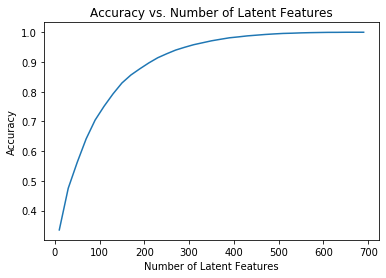

In [71]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [72]:
print(unique_articles, # The number of unique articles that have at least one interaction
total_articles, # The number of unique articles on the IBM platform
unique_users, # The number of unique users
user_article_interactions,)

714 1051 5148 45993


In [73]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = user_item_test.index.values
    test_arts = user_item_test.columns.get_level_values('article_id').tolist()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [74]:
# How many users can we make predictions for in the test set?
dup_idx = user_item_train.index.isin(user_item_test.index)
dup_ids = [idx for idx in user_item_test.index.values if idx in user_item_train.index.values]
sum(dup_idx),len(dup_ids)

(20, 20)

In [75]:
# How many users in the test set are we not able to make predictions for because of the cold start problem?
miss_match_ids = [idx for idx in user_item_test.index.values if idx  not in user_item_train.index.values]
len(miss_match_ids)

662

In [76]:
# How many articles can we make predictions for in the test set?
dup_art_ids_col_idx = user_item_train.columns.isin(user_item_test.columns)
sum(dup_art_ids_col_idx)

574

In [77]:
# How many articles in the test set are we not able to make predictions for because of the cold start problem?
artid_test = user_item_test.columns.get_level_values('article_id').to_list()
artid_train = user_item_train.columns.get_level_values('article_id').to_list()
len([idx for idx in artid_test if idx not in artid_train])

0

In [78]:
# How many articles in the train set
len(artid_train)

714

In [79]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [80]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

# Solution One

In [82]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

user_item_test = user_item_test.loc[dup_ids]

num_latent_feats = np.arange(10,710,20)
sum_acc_train = []
sum_acc_test = []
sum_f1_train = []
sum_f1_test = []
sum_recall_train = []
sum_recall_test = []
sum_precision_train = []
sum_precision_test = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    s_test_new, u_test_new, vt_test_new = s_train_new, u_train_new[dup_idx], vt_train_new[:,dup_art_ids_col_idx]
    
    # take dot product
    user_item_est_train = np.clip(np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new)),0,1)
    user_item_est_test = np.clip(np.around(np.dot(np.dot(u_test_new, s_test_new), vt_test_new)),0,1)
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_est_train)
    diffs_test = np.subtract(user_item_test, user_item_est_test)
    f1_train = f1_score(user_item_train.values.flatten(),user_item_est_train.flatten())
    f1_test = f1_score(user_item_test.values.flatten(),user_item_est_test.flatten())
    precision_train = precision_score(user_item_train.values.flatten(),user_item_est_train.flatten())
    precision_test = precision_score(user_item_test.values.flatten(),user_item_est_test.flatten())
    recall_train = recall_score(user_item_train.values.flatten(),user_item_est_train.flatten())
    recall_test = recall_score(user_item_test.values.flatten(),user_item_est_test.flatten())
    print(classification_report(user_item_test.values.flatten(),user_item_est_test.flatten()))
    
    # total errors and keep track of them
    acc_train = np.sum(np.sum(np.abs(diffs_train)))
    sum_acc_train.append(acc_train)
    acc_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_acc_test.append(acc_test)
    sum_f1_train.append(f1_train)
    sum_f1_test.append(f1_test)
    sum_recall_train.append(recall_train)
    sum_recall_test.append(recall_test)
    sum_precision_train.append(precision_train)
    sum_precision_test.append(recall_test)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     11262
           1       0.20      0.05      0.07       218

    accuracy                           0.98     11480
   macro avg       0.59      0.52      0.53     11480
weighted avg       0.97      0.98      0.97     11480

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     11262
           1       0.21      0.09      0.12       218

    accuracy                           0.98     11480
   macro avg       0.60      0.54      0.56     11480
weighted avg       0.97      0.98      0.97     11480

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     11262
           1       0.20      0.10      0.13       218

    accuracy                           0.98     11480
   macro avg       0.59      0.54      0.56     11480
weighted avg       0.97      0.98      0.97     11480

              preci

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11262
           1       0.11      0.12      0.12       218

    accuracy                           0.96     11480
   macro avg       0.55      0.55      0.55     11480
weighted avg       0.97      0.96      0.97     11480

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11262
           1       0.11      0.12      0.12       218

    accuracy                           0.96     11480
   macro avg       0.55      0.55      0.55     11480
weighted avg       0.97      0.96      0.97     11480

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11262
           1       0.11      0.12      0.12       218

    accuracy                           0.96     11480
   macro avg       0.55      0.55      0.55     11480
weighted avg       0.97      0.96      0.97     11480

              preci

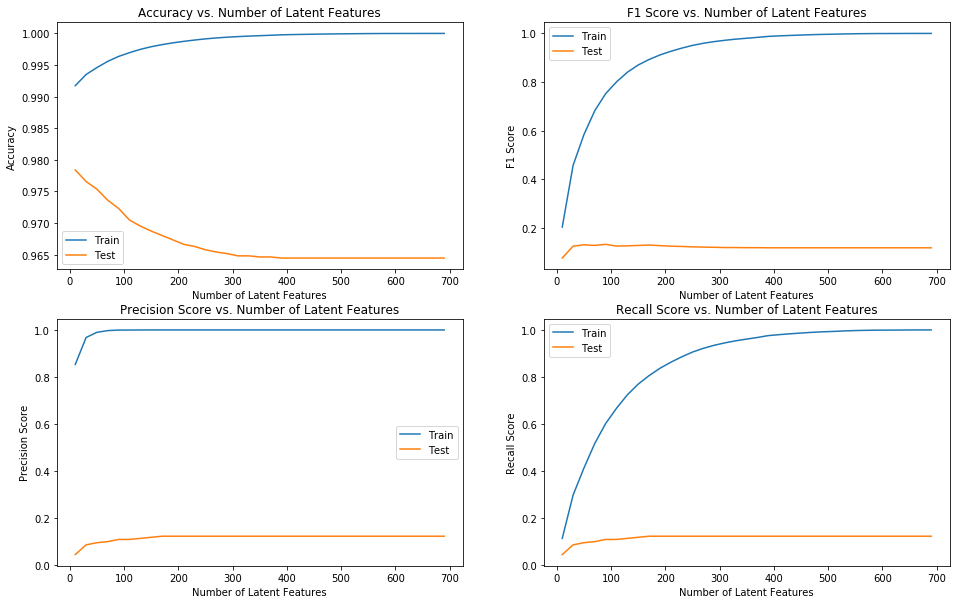

In [84]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes[0][0].plot(num_latent_feats, 1 - np.array(sum_acc_train)/np.product(user_item_est_train.shape),label='Train');
axes[0][0].plot(num_latent_feats, 1 - np.array(sum_acc_test)/np.product(user_item_est_test.shape),label='Test');
axes[0][0].set_xlabel('Number of Latent Features');
axes[0][0].set_ylabel('Accuracy');
axes[0][0].set_title('Accuracy vs. Number of Latent Features');
axes[0][0].legend();

axes[0][1].plot(num_latent_feats, sum_f1_train,label='Train');
axes[0][1].plot(num_latent_feats, sum_f1_test,label='Test');
axes[0][1].set_xlabel('Number of Latent Features');
axes[0][1].set_ylabel('F1 Score');
axes[0][1].set_title('F1 Score vs. Number of Latent Features');
axes[0][1].legend();

axes[1][0].plot(num_latent_feats, sum_precision_train,label='Train');
axes[1][0].plot(num_latent_feats, sum_precision_test,label='Test');
axes[1][0].set_xlabel('Number of Latent Features');
axes[1][0].set_ylabel('Precision Score');
axes[1][0].set_title('Precision Score vs. Number of Latent Features');
axes[1][0].legend();

axes[1][1].plot(num_latent_feats, sum_recall_train,label='Train');
axes[1][1].plot(num_latent_feats, sum_recall_test,label='Test');
axes[1][1].set_xlabel('Number of Latent Features');
axes[1][1].set_ylabel('Recall Score');
axes[1][1].set_title('Recall Score vs. Number of Latent Features');
axes[1][1].legend();

In [85]:
# Training-set interactions count by the 20 test-users
# This can be comparied with the over-all count by the same users
u20_train_interactions = pd.DataFrame(user_item_test.sum(axis=1).sort_values()).reset_index()
u20_train_interactions.columns=['user_id','count_train']
u20_train_interactions

,user_id,count_train
0,3990,1
1,3989,1
2,3527,1
3,3777,1
4,2917,2
5,4204,2
6,3684,3
7,4487,4
8,3193,5
9,3093,5


# Solution Two

In [86]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    test_ids = [uid for uid in df_test.user_id.unique() if uid in df_train.user_id.unique()]
    user_item_train = create_user_item_matrix(df_train)
    user_item_all = create_user_item_matrix(df)
    user_item_test = user_item_all[user_item_all.index.isin(test_ids)]
#     test_arts = user_item_test.columns.get_level_values('article_id').tolist()
    
    return user_item_train, user_item_test

user_item_train, user_item_test = create_test_and_train_user_item(df_train, df_test)
user_item_train.shape,user_item_test.shape

((4487, 714), (20, 714))

In [87]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

num_latent_feats = np.arange(10,710,20)
sum_acc_train = []
sum_acc_test = []
sum_f1_train = []
sum_f1_test = []
sum_recall_train = []
sum_recall_test = []
sum_precision_train = []
sum_precision_test = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    s_test_new, u_test_new, vt_test_new = s_train_new, u_train_new[dup_idx], vt_train_new
    
    # take dot product
    user_item_est_train = np.clip(np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new)),0,1)
    user_item_est_test = np.clip(np.around(np.dot(np.dot(u_test_new, s_test_new), vt_test_new)),0,1)
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_est_train)
    diffs_test = np.subtract(user_item_test, user_item_est_test)
    f1_train = f1_score(user_item_train.values.flatten(),user_item_est_train.flatten())
    f1_test = f1_score(user_item_test.values.flatten(),user_item_est_test.flatten())
    precision_train = precision_score(user_item_train.values.flatten(),user_item_est_train.flatten())
    precision_test = precision_score(user_item_test.values.flatten(),user_item_est_test.flatten())
    recall_train = recall_score(user_item_train.values.flatten(),user_item_est_train.flatten())
    recall_test = recall_score(user_item_test.values.flatten(),user_item_est_test.flatten())
    print(classification_report(user_item_test.values.flatten(),user_item_est_test.flatten()))
    
    # total errors and keep track of them
    acc_train = np.sum(np.sum(np.abs(diffs_train)))
    sum_acc_train.append(acc_test)
    acc_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_acc_test.append(acc_test)
    sum_f1_train.append(f1_train)
    sum_f1_test.append(f1_test)
    sum_recall_train.append(recall_train)
    sum_recall_test.append(recall_test)
    sum_precision_train.append(precision_train)
    sum_precision_test.append(recall_test)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     13833
           1       0.88      0.10      0.18       447

    accuracy                           0.97     14280
   macro avg       0.93      0.55      0.58     14280
weighted avg       0.97      0.97      0.96     14280

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     13833
           1       0.97      0.19      0.32       447

    accuracy                           0.97     14280
   macro avg       0.97      0.60      0.65     14280
weighted avg       0.97      0.97      0.97     14280

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     13833
           1       1.00      0.24      0.39       447

    accuracy                           0.98     14280
   macro avg       0.99      0.62      0.69     14280
weighted avg       0.98      0.98      0.97     14280

              preci

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     13833
           1       1.00      0.57      0.72       447

    accuracy                           0.99     14280
   macro avg       0.99      0.78      0.86     14280
weighted avg       0.99      0.99      0.98     14280

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     13833
           1       1.00      0.57      0.72       447

    accuracy                           0.99     14280
   macro avg       0.99      0.78      0.86     14280
weighted avg       0.99      0.99      0.98     14280

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     13833
           1       1.00      0.57      0.73       447

    accuracy                           0.99     14280
   macro avg       0.99      0.79      0.86     14280
weighted avg       0.99      0.99      0.98     14280

              preci

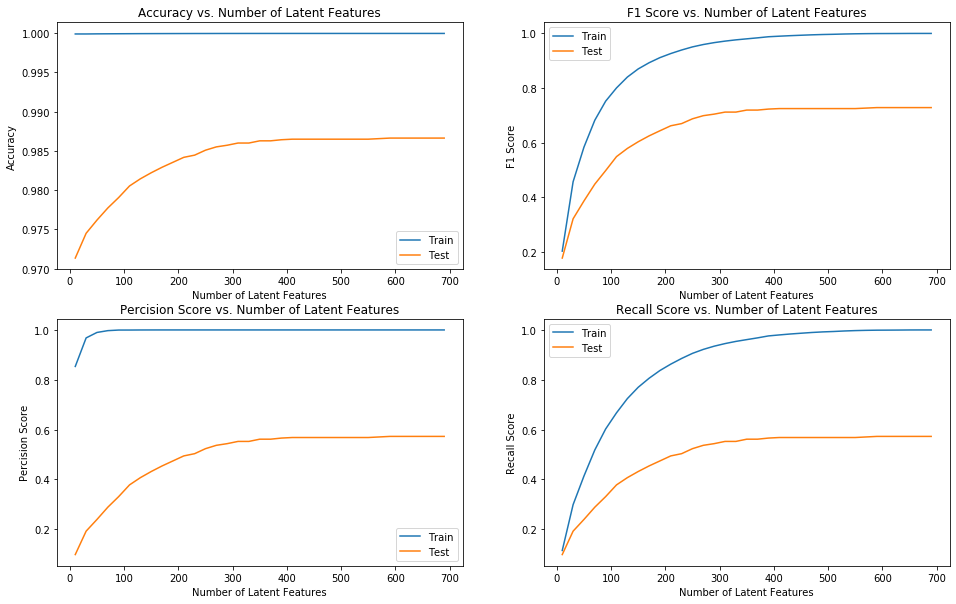

In [88]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes[0][0].plot(num_latent_feats, 1 - np.array(sum_acc_train)/np.product(user_item_est_train.shape),label='Train');
axes[0][0].plot(num_latent_feats, 1 - np.array(sum_acc_test)/np.product(user_item_est_test.shape),label='Test');
axes[0][0].set_xlabel('Number of Latent Features');
axes[0][0].set_ylabel('Accuracy');
axes[0][0].set_title('Accuracy vs. Number of Latent Features');
axes[0][0].legend();

axes[0][1].plot(num_latent_feats, sum_f1_train,label='Train');
axes[0][1].plot(num_latent_feats, sum_f1_test,label='Test');
axes[0][1].set_xlabel('Number of Latent Features');
axes[0][1].set_ylabel('F1 Score');
axes[0][1].set_title('F1 Score vs. Number of Latent Features');
axes[0][1].legend();

axes[1][0].plot(num_latent_feats, sum_precision_train,label='Train');
axes[1][0].plot(num_latent_feats, sum_precision_test,label='Test');
axes[1][0].set_xlabel('Number of Latent Features');
axes[1][0].set_ylabel('Percision Score');
axes[1][0].set_title('Percision Score vs. Number of Latent Features');
axes[1][0].legend();

axes[1][1].plot(num_latent_feats, sum_recall_train,label='Train');
axes[1][1].plot(num_latent_feats, sum_recall_test,label='Test');
axes[1][1].set_xlabel('Number of Latent Features');
axes[1][1].set_ylabel('Recall Score');
axes[1][1].set_title('Recall Score vs. Number of Latent Features');
axes[1][1].legend();

In [89]:
# Train_set vs All_set interactions count by the 20 test-users
u20_all_interactions = pd.DataFrame(user_item_test.sum(axis=1).sort_values()).reset_index()
u20_all_interactions.columns=['user_id','count_all']
u20_interactions=pd.merge(u20_train_interactions,u20_all_interactions,on='user_id')
u20_interactions

,user_id,count_train,count_all
0,3990,1,2
1,3989,1,2
2,3527,1,5
3,3777,1,2
4,2917,2,13
5,4204,2,26
6,3684,3,37
7,4487,4,18
8,3193,5,6
9,3093,5,17


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

As I was working through the question 5, I found one glitch which is a misleading instruction. Particularly in question 4, create_test_and_train_user_item() section, where it says "user_item_test - a user-item matrix of the testing data frame". By following so, the test matrix will only contain the partial truth considering how the testing data frame is formed, which is just the tail portion of the df(all the interactions). Thus, the Accuracy, the F1 score, and the Precision score would all be meaningless, because of the unreliable false-positives. Something the SVD predicts right could well end up being the truth in the past but since the testing data frame was trimmed right off from the tail of the df, there is no data to back-up the truth from the past. Hence, the test scores are very low and inaccurate. 

But we could still consider the tendency of the scores as useful. I think only the Recall sore from Solution One is somewhat meaningful, as it tells that out of all the actual interactions within df_test, what portion has the model predicted right. Which is not that impressive either, and my theory to that is it would be very difficult to measure performance with a large number of available items to choose from, plus there is also lack of actual interactions in place. Because it would make perfect sense to have a large amount of very similar items, yet, against all odds and having predicting 'the right result' vs 'many other alternatives doesn't always yield the most accurate scores. 

As for the accuracy score, 95% would be the bottom line as most of the data points are zeros. And for the accuracy going downwards, I think it is due to the sample size. Given the test set only includes 20 rows, it would be hard to judge the effectiveness of the model. For the Accuracy to show an uptrend, we would need a larger sample size to aggregate from.

In Solution Two, I used the 20 user_ids from the df_test to filter out all the interactions from the entire dataset to form the test matrix, a sort of using the partial picture to predict the bigger picture approach.  As it illustrates in the above graphs, it was really difficult to predict 'the exact future' as 'the future' in some circumstances turns out largely due to tendency plus chance. Again, I want to blame the test sample size and the current cold climate (all the zeros) for the droopy performance on the test set. 

It appears to be overfitting at the larger end of the latent features, considering the resources, we could limit the number of latent features to 200 or less.

Depends on how the rank-based recommender system was initially staged, sometimes, we could end-up having dramatically different landscapes in terms of item popularity. For instance, in our rank-based system, we could have items that are popular largely due to chance, because the first batch of items that received click would have competitive advantages over the rest items in terms of popularity and rank. To mitigate this we could adopt user ratings and rank items base on the overall ratings or popularity over certain periods, like daily, weekly monthly, and so on.

In the end, a successful recommender system is all about combining all kinds of approaches to make the end recommendations as effective yet as diverse as possible. Conduct A/B testing whenever possible with a well-defined matrix to keep the end-goal in check seems a widely adopted approach.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])